In [4]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
import logging


def allow_soft_placement():
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if  len(physical_devices) == 0:
        logging.warning("Not enough GPU hardware devices available")
    else:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

allow_soft_placement()

import os
os.chdir('../src/models/')

import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
from hyperopt import space_eval
sys.path.append(os.path.abspath("../.."))
sys.path.append(os.path.abspath('../code_snippets/'))

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
# load up the entries as environment variables
load_dotenv(dotenv_path)
# import pandas as pd

import random
import matplotlib.pyplot as plt
from src.code_snippets.utils.data_handler import read_pickle,save_to_pickle
from src.code_snippets.models.many_to_one_models import BidirectionalLSTM
from src.code_snippets.models.hyperparameter_tuning import safeHyperopt,extract_trial_results
import seaborn as sns
from hyperopt import hp, space_eval
from src.code_snippets.visualization.hyperparameter_tuning import analyze_hyperparameters

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


ModuleNotFoundError: No module named 'scikitplot'

In [ ]:
from src.code_snippets.evaluation.model_evaluation import plot_metrics

In [ ]:
seed = 100
random.seed(seed)
np.random.seed(seed)

In [ ]:
train_data = read_pickle('../../data/processed/processed_data_train.pickle')
val_data = read_pickle('../../data/processed/processed_data_val.pickle')
test_data = read_pickle('../../data/processed/processed_data_test.pickle')


In [ ]:
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
assert num_gpus_available == 1, 'GPU IS NOT AVAILABLE' 
print("Num GPUs Available: ",num_gpus_available )

In [42]:
trials = read_pickle('../../models/BidirectionalLSTM/V3/trials.pickle')
space = read_pickle('../../models/BidirectionalLSTM/V3/space_hyperopt.pickle')

In [8]:
'''experiments_dict= {}
for k in space.keys():
    experiments_dict[k] = [sample(space)[k] for i in range(1000)]'''

'experiments_dict= {}\nfor k in space.keys():\n    experiments_dict[k] = [sample(space)[k] for i in range(1000)]'

In [9]:
'''{k:[min(v),max(v)] for k,v in experiments_dict.items()}'''

'{k:[min(v),max(v)] for k,v in experiments_dict.items()}'

In [10]:
best_params = space_eval(space,trials.argmin) 
print(trials.best_trial['result']['loss'])
best_params


0.1782764196395874


{'add_recurrent_layer': True,
 'batch_size': 512,
 'bidirectional': True,
 'dropout': 0.5,
 'epochs': 100,
 'global_avg_pool': True,
 'global_max_pool': False,
 'hidden_dense_units': 32,
 'learning_rate': 0.002148295895191754,
 'n_units': 64,
 'spatial_dropout': 0.4000000000000001}

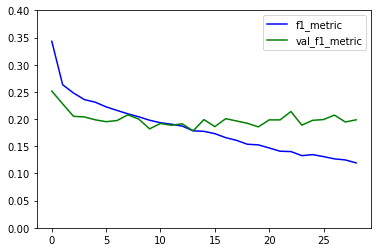

In [10]:
plot_metrics(
             trials.best_trial['result']['model_history'],
             ylim=(0,0.4)
                )

In [11]:
results = list(map(lambda x: extract_trial_results(x,space),trials.trials))

In [12]:
results = pd.DataFrame(results)
results.drop('epochs',axis=1,inplace=True)
results.sort_values(by='f1_val',inplace=True,ascending=False)

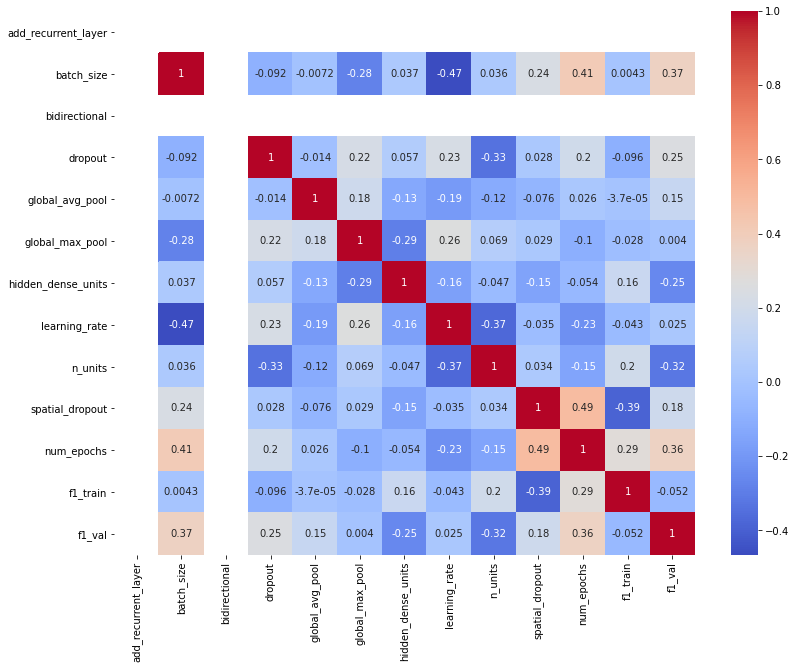

In [13]:
plt.figure(figsize=(13,10))
sns.heatmap(results[results['hidden_dense_units']>0].corr(),cmap='coolwarm',annot=True)
plt.show()

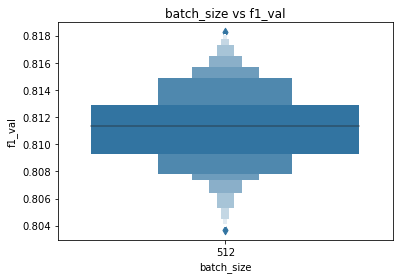

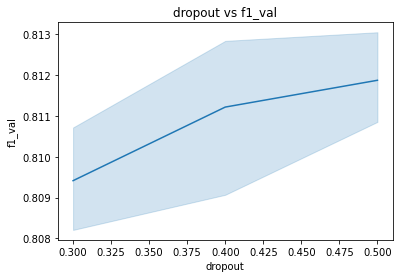

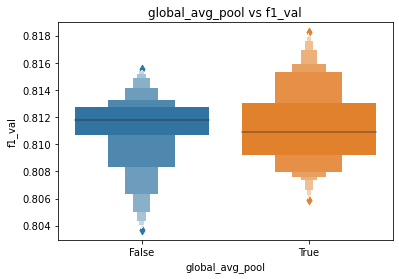

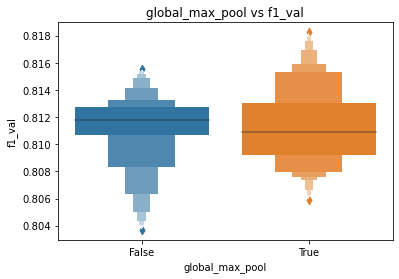

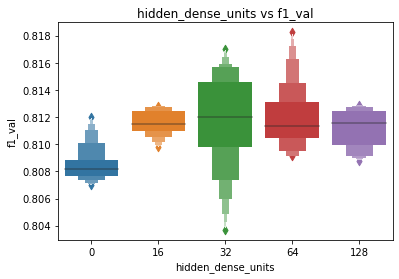

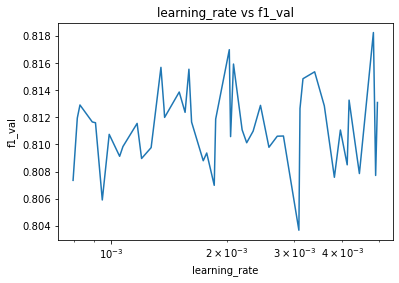

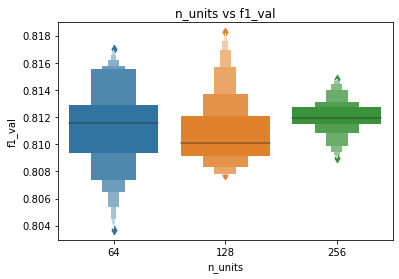

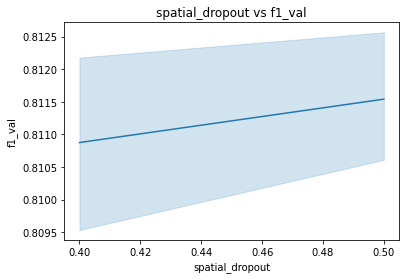

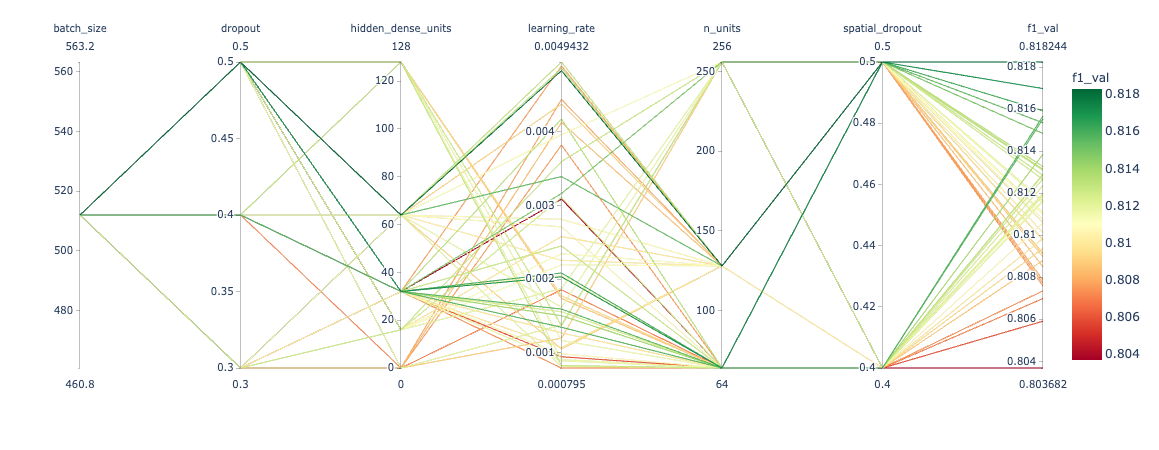

In [49]:
hyperparameters = [   'batch_size', 'dropout',
                      'global_avg_pool', 'global_max_pool',
                      'hidden_dense_units','learning_rate',
                      'n_units', 'spatial_dropout' ]
data = results
log_scale_vars = ['learning_rate']
score_col = 'f1_val'
analyze_hyperparameters(data,score_col,hyperparameters,log_scale_vars)

# Refined Grid Search

In [48]:
trainer = BidirectionalLSTM(train_data,
                            val_data,
                            "../../data/raw/pretrained_embeddings/glove.twitter.27B/glove.twitter.27B.200d.txt")


NameError: name 'BidirectionalLSTM' is not defined

In [9]:
from itertools import product

In [39]:
space = {'add_recurrent_layer': [True],
         'batch_size': [512],
         'bidirectional': [True],
         'dropout': [0.5],
         'epochs': [100],
         'global_avg_pool': [True],
         'global_max_pool': [False],
         'hidden_dense_units': np.append([0],2**np.arange(4,8,dtype=int)),
         'learning_rate': [0.002148295895191754],
         'n_units': 2**np.arange(6,9,dtype=int),
         'spatial_dropout': [0.4000000000000001]}


In [47]:
combinations = list(product(*[i for i in space.values()]))
combinations = [dict(zip(space.keys(),i)) for i in combinations]
trials = []
for c in combinations:
    trials.append(trainer.hyperopt_model(c))

NameError: name 'trainer' is not defined

In [26]:
n_units_grid = 2**np.arange(6,9,dtype=int)
hidden_dense_units_grid = np.append([0],2**np.arange(4,8,dtype=int))
combinations = list(product(n_units_grid,hidden_dense_units_grid))
combinations =[i for i in combinations if i[0]>=i[1]]

In [ ]:

for n_units,hidden_dense_units in combinations:
    trainer.set_model(
        add_recurrent_layer = True,
        bidirectional = True,
        dropout = 0.5,
        global_avg_pool =  True,
        global_max_pool = False,
        hidden_dense_units =  32,
        learning_rate = 0.002148295895191754,
        n_units = n_units,
        spatial_dropout= 0.4000000000000001
        )

trainer.fit(epochs =  100,batch_size =  512)

In [ ]:
lrs = 10.0**(np.arange(-2,-3,-1))
results = {}
for lr in lrs:
    trainer.set_model(n_units = 128,
                      learning_rate=lr,
                      hidden_dense_units = 64,
                      dropout=0,
                      spatial_dropout=0,
                      add_recurrent_layer = True)

    trainer.fit_model(batch_size=128,epochs = 10,use_early_stopping=True)
    results[lr] = {'history':trainer.history.history,'score':trainer.early_stopping.best}

# Learning Rate decay

# =======================================================================================

# Evaluate

In [15]:
from src.code_snippets.evaluation.model_evaluation import f1_metric
model = tf.keras.models.load_model('../../models/BidirectionalLSTM/model.h5',custom_objects={'f1_metric':f1_metric})

trainer = BidirectionalLSTM(train_data,
                            val_data,
                            "../../data/raw/pretrained_embeddings/glove.twitter.27B/glove.twitter.27B.200d.txt",
                            model=model)


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:

In [16]:
trainer.generate_metrics(trainer.val_data['X_indices'],y_test = trainer.val_data['y'])

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

0.8225806

In [18]:
preds = model.predict(test_data['X_indices'])
f1_metric(test_data['y'].astype('float32'),preds)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0


<tf.Tensor: shape=(), dtype=float32, numpy=0.8157349>

In [19]:
from scikitplot.metrics import plot_confusion_matrix

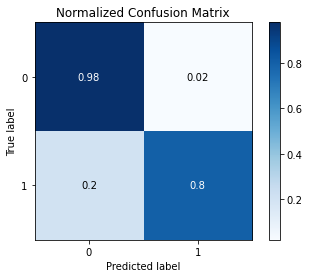

In [20]:
plot_confusion_matrix(test_data['y'],(preds>=0.5)*1,normalize=True)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


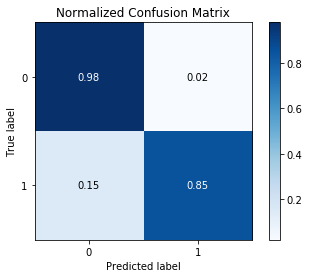

In [105]:
plot_confusion_matrix(val_data['y'],(model.predict(val_data['X_indices'])>=0.5)*1,normalize=True)

In [91]:
roc_auc_score(val_data['y'],model.predict(val_data['X_indices']))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


0.9875213572949819

In [ ]:
def get_layer_output(model,layer,input_):
    get_layer_output = K.function([model.layers[0].input],
                      [model.layers[layer].output])

    layer_output = get_layer_output(input_)
    return layer_output[0]

In [19]:
trainer.model(n_units=256,
             add_recurrent_layer=True,
             dropout=0.4,
             spatial_dropout=0.4,
             hidden_dense_units=128,
             learning_rate=0.0017436142055397088,
             global_avg_pool=False,
             global_max_pool=False
    )



In [20]:
trainer.model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 115)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 115, 200)          238703000 
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 115, 200)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 115, 512)          935936    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512 

In [21]:
trainer.fit_model(epochs=100,batch_size = 128)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Prefet

In [31]:
test = trainer.val_data['X_indices']
y_true = trainer.val_data['y'].astype('float32')

y_pred = trainer.model.predict(test)

score = f1_metric(y_true,y_pred).numpy()

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [45]:
model = tf.keras.models.load_model('../../models/many_to_one_LSTM/model.h5',custom_objects={'f1_metric':f1_metric})

Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:lo

In [46]:
trainer.model = model

In [47]:
trainer.generate_metrics(trainer.val_data['X_indices'],y_test = trainer.val_data['y'])

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_143037 in device /job:localhost/replica:0/task:0/device:GPU:0


0.8555478

In [ ]:
plt.figure(figsize=(10,10))
sns.lineplot(x='learning_rate',y='f1_val',data = results)
plt.xscale('log')
plt.axvline(3.5e-3)
plt.show()

In [ ]:
np.round(np.log10(3.5e-3),4)

In [43]:
os.getcwd()

'/home/samir/temp/toxic_comments/src/models'

In [ ]:
10**-2.5